
# Two Centuries Inc.
## Glassdoor NLP project
##### Date: May, 2022
##### Multi-label Multi-class Classification 


In [4]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter
from wordcloud import WordCloud # for visualization
from termcolor import colored
import re, string, math
# from langdetect import detect # language detection

# import NLP library
# POS, Stemmer, Truecase
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
# spacy for tagging 
import spacy  # en_core_web_sm
from sklearn.feature_extraction import text
stop = text.ENGLISH_STOP_WORDS


# ML models
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# deep learning
import transformers
from transformers import AutoModel, BertTokenizerFast

# embedding 
# sentence embedding , #featues 512
import tensorflow_hub as hub
import tensorflow_text  # this needs to be imported to set up some stuff in the background
# embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")


In [5]:
# input files
path="/Users/yuenyeelo/Documents/Jobs/TwoCenturies/NLP_classifier/"
#trainfile=path+"./data/test.csv" # small file for testing
trainfile=path+"./data/glassdoor_reviews_selected12.csv"
embd_model=path+"models"  # universal_sentence embedding , pretrain model
topic_excel_file=path+"topic/TwoCenturies_Glassdoor_topic_seedwords.xlsx"


feat_cols=['summary', 'pros_description', 'cons_description', 'advice_to_management']

### Load data 
##### Check count of tn_id and company names

In [6]:
# check count of tn_id, and company names
def printTNID_COName(subset_train_df):
    print(subset_train_df.shape)
    print(subset_train_df['tn_id'].value_counts())
    #print(gd_df['employer_name'].unique())
    print(subset_train_df['employer_name'].value_counts())
    #print(subset_train_df['pros_description'][:20])

In [7]:
# read pdf
gd_df=pd.read_csv(trainfile)
printTNID_COName(gd_df)
gd_df.head()

/Users/yuenyeelo/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (13,36,37,45,46,47,48) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(79372, 50)
nasdaq:tmus    22031
nasdaq:amzn    20305
nasdaq:msft    18917
nasdaq:aapl    11788
nyse:crm        3611
nasdaq:okta      779
nyse:hubs        597
nyse:pins        559
nyse:mkl         298
nyse:pd          295
nasdaq:frog      169
nyse:knsl         23
Name: tn_id, dtype: int64
Amazon                       20305
Microsoft                    18917
T-Mobile                     12792
Apple                        11788
Sprint                        9239
Salesforce                    3611
Okta                           690
HubSpot                        597
Pinterest                      559
Markel                         298
PagerDuty                      295
JFrog                          169
Auth0                           89
Kinsale Insurance Company       23
Name: employer_name, dtype: int64


,tn_id,dataset__entity__name,#security.cusip,isin,id,as_of_date,url,company_logo,employer_name,author_title,...,date_added,date_updated,dataset__entity__entity_ticker__ticker__market_sector,dataset__entity__entity_ticker__ticker__market_industry,scrape_date,#company.gics_sector,#company.gics_industry,#company.icb_industry,#company.icb_sector,Unnamed: 0
0,nasdaq:tmus,https://www.glassdoor.com?employer_id=9302,872590104,us8725901040,574817,2018-03-12,https://www.glassdoor.com/Reviews/Employee-Rev...,https://media.glassdoor.com/sqls/9302/t-mobile...,T-Mobile,Former Employee - Anonymous Employee,...,20180329T161136Z,20180329T161136Z,Telecommunications,Mobile Telecommunications,2018-03-31,NaN,NaN,NaN,NaN,NaN
1,nasdaq:tmus,https://www.glassdoor.com?employer_id=9302,872590104,us8725901040,574838,2018-01-30,https://www.glassdoor.com/Reviews/Employee-Rev...,https://media.glassdoor.com/sqls/9302/t-mobile...,T-Mobile,Former Employee - Retail Associate Manager,...,20180329T161136Z,20180329T161136Z,Telecommunications,Mobile Telecommunications,2018-03-31,NaN,NaN,NaN,NaN,NaN
2,nasdaq:tmus,https://www.glassdoor.com?employer_id=9302,872590104,us8725901040,574929,2018-01-18,https://www.glassdoor.com/Reviews/Employee-Rev...,https://media.glassdoor.com/sqls/9302/t-mobile...,T-Mobile,Current Employee - Director,...,20180329T161136Z,20180329T161136Z,Telecommunications,Mobile Telecommunications,2018-03-31,NaN,NaN,NaN,NaN,NaN
3,nasdaq:tmus,https://www.glassdoor.com?employer_id=9302,872590104,us8725901040,574664,2018-01-11,https://www.glassdoor.com/Reviews/Employee-Rev...,https://media.glassdoor.com/sqls/9302/t-mobile...,T-Mobile,Former Employee - Anonymous Human Resources,...,20180329T161136Z,20180329T161136Z,Telecommunications,Mobile Telecommunications,2018-03-31,NaN,NaN,NaN,NaN,NaN
4,nasdaq:tmus,https://www.glassdoor.com?employer_id=9302,872590104,us8725901040,574798,2017-10-24,https://www.glassdoor.com/Reviews/Employee-Rev...,https://media.glassdoor.com/sqls/9302/t-mobile...,T-Mobile,Former Employee - Anonymous Employee,...,20180329T161136Z,20180329T161136Z,Telecommunications,Mobile Telecommunications,2018-03-31,NaN,NaN,NaN,NaN,NaN


## Data wrangling (preprocessing)

#### language id 
#### clean punctuniations
#### remove non english chars 
#### remove stop words

In [8]:
# Data wrangling 
# drop na

# Â 
def clean_text(text):
    # text = re.sub(r"\'s", " ", text)
    text = re.sub(r"don\'t", "do not ", text)
    text = re.sub(r"n\'t", " not ", text)
    text = re.sub(r"i\'m", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)

    text = text.strip(' ')    
    return text

# we should have a list of company names, langauges, etc. Spacy is case sensitive when tagging NE.
# plus the slang "idk, jk, ttyl" 
# we can unsupervised extracted from the corpus, using spacy chunk 

def porter_stem(text):
    l=[]
    for w in text.split():
        s=stemmer.stem(w)
        l.append(s)
    return " ".join(l)


In [9]:
# language detection, not perfect yet
# many "none" or NA
# short message cant be detect, or mis detect

def checkLang(df, col_name):
    tLang=[]
    for l in df[col_name]:

        if len(l) == 0:
            #print("NaN")
            tLang.append(np.nan)
        elif l == "none" or l == "na" :
            tLang.append(np.nan)
        else:
            
            if len(l) <= 50:
                tLang.append("en")
            else:
                lang = detect(l)
                
                tLang.append(lang)
                #if lang != "en":
                 #   print(lang, l, len(l))
    return tLang


In [10]:

def preProcess(gd_df, cols):
    tmp_df=gd_df
    ## we cannot 
    tmp_df.fillna('[SEP]', inplace=True)
    for col_name in cols:
        print(col_name)
        tmp_df[col_name]= tmp_df[col_name].str.lower()
        tmp_df[col_name]=tmp_df[col_name].apply(lambda x: ''.join([" " if ord(i) < 32 or ord(i) > 126 else i for i in x]))
        tmp_df[col_name]= tmp_df[col_name].apply(clean_text)
        tmp_df[col_name].replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=["",""], regex=True, inplace=True)   
        tmp_df[col_name] = tmp_df[col_name].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
        tmp_df[col_name]= tmp_df[col_name].str.strip()
        ## [SEP] problem here
        tmp_df[col_name].replace(r'^sep$','[SEP]',inplace=True)
    print(tmp_df.shape)
    return tmp_df

    #print(tmp_df[col_name].isnull().sum())
    # detect language
    # lang=checkLang(tmp_df, col_name)
    # tmp_df['detected_language']=lang
    # drop out non-english
    # tmp_df.drop(tmp_df[tmp_df['lang'] != 'en'].index, inplace = True)
    
# y_df=preProcess(gd_df, "cons_description")

In [ ]:
# pre-processing data and store in df_cleaned
# Fill nan as "[SEP]" for now
gd_df_sub=pd.DataFrame(gd_df[['id','tn_id','as_of_date','summary','pros_description','cons_description','advice_to_management']])
print(gd_df_sub.shape)
print(gd_df_sub.info())
print(gd_df_sub.isna().sum())
df_cleaned=preProcess(gd_df_sub, feat_cols)
# check the shape
print(df_cleaned.shape)
print(gd_df_sub.shape)
df_cleaned.head()

(79372, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79372 entries, 0 to 79371
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    79372 non-null  int64 
 1   tn_id                 79372 non-null  object
 2   as_of_date            79372 non-null  object
 3   summary               79287 non-null  object
 4   pros_description      79372 non-null  object
 5   cons_description      79372 non-null  object
 6   advice_to_management  44409 non-null  object
dtypes: int64(1), object(6)
memory usage: 4.2+ MB
None
id                          0
tn_id                       0
as_of_date                  0
summary                    85
pros_description            0
cons_description            0
advice_to_management    34963
dtype: int64
summary
pros_description


0                                                               organized company good work life balance
1    great cultureawesome benefits stock options 401k match pto easy lateral movementmanagers lead ex...
Name: pros_description, dtype: object


,id,tn_id,as_of_date,summary,pros_description,cons_description,advice_to_management,word_cnt
9446,2332124,nasdaq:okta,2016-01-20,love working okta,colleagues teach challenge motivate people okta smart learn new things new people day constantly...,401 k match gym programs ironic ceo super fit clear multiple times company management strategica...,transparency don t loosen hiring standards continue grow make easy employees does internal proce...,696
32762,57293,nasdaq:amzn,2017-07-07,outstanding company loyal employee thank,pros words dan pink motivation things make happy work just focused money pay people money list c...,really thing element enjoyed role don t negative say area heavy administration sa tools place su...,doing right don t stop iterating innovating supporting members team built truly unique working s...,439
63104,40107,nasdaq:amzn,2014-09-19,huge diverse high tech company sorts stuff,disclaimer opinions reflect sde amazon like operational job functions tough read amazon reviews ...,beware bad managers horrible team mates specific amazon exist amazon admit monday usually blue d...,thing thinking long term getting worrying company turned tidy profit trying conquer world lofty ...,481


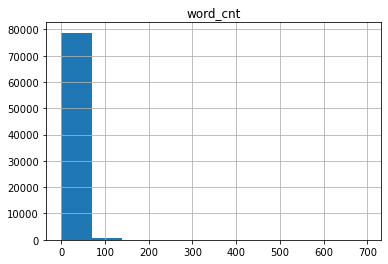

In [94]:
# check the len of the reviews, some reviews have lot of words
print(df_cleaned['pros_description'][:2])
df_cleaned['word_cnt']=df_cleaned['pros_description'].str.split().apply(len)
df_cleaned.hist("word_cnt",bins=10)
df_cleaned[df_cleaned['word_cnt']>400]

# Embedding
Pretrain sentence embedding for sentence vectorization. see https://tfhub.dev/google/universal-sentence-encoder-multilingual/3 for detail.

In [95]:
# load embedding model
embed = hub.load(embd_model)

INFO:absl:resolver HttpCompressedFileResolver does not support the provided handle.
INFO:absl:resolver GcsCompressedFileResolver does not support the provided handle.


In [96]:

def run_embedding(X_test, embed, batch_size):
    n=len(X_test)
    k=math.ceil(n/batch_size)
    X_embeddeds=[]
    print("Start Embedding", datetime.now())
    for i in range(k):
        batch=X_test[i*batch_size:(i+1)*batch_size]
        X_embedded=embed(batch)
        X_embedded_arr=np.array(X_embedded).tolist()
        X_embeddeds+=X_embedded_arr
    #print(X_test.shape , len(X_embeddeds))
    print("Finish Embedding", datetime.now())
    return X_embeddeds
    

#X_test_pros=df_cleaned['pros_description']
#X_test_embedded = run_embedding(X_test_pros[:250], embed, 100)


In [97]:
# embedd the test data
# it takes long time to embed the data
# We should do it in smaller tunck and concat it ....
batch_size=10000
X_test_pros=df_cleaned['pros_description']
X_test_pros_embedded = run_embedding(X_test_pros, embed, batch_size)

X_test_cons=df_cleaned['cons_description']
X_test_cons_embedded = run_embedding(X_test_cons, embed, batch_size)

X_test_mgr=df_cleaned['advice_to_management']
X_test_mgr_embedded = run_embedding(X_test_mgr, embed, batch_size)

X_test_summary=df_cleaned['summary']
X_test_summary_embedded = run_embedding(X_test_summary, embed, batch_size)

Start Embedding 2022-05-25 20:57:39.458821


Finish Embedding 2022-05-25 21:00:04.037060
Start Embedding 2022-05-25 21:00:05.592103
Finish Embedding 2022-05-25 21:03:28.273486
Start Embedding 2022-05-25 21:03:34.534134
Finish Embedding 2022-05-25 21:05:05.976002
Start Embedding 2022-05-25 21:05:12.186123
Finish Embedding 2022-05-25 21:06:01.281285


## Build Topics
#### Read topic seedwords file  (excel file)
#### Defined  topics:  topics from CultureX, plus "benefit" and "Management", "Career"
#### Check the latest topic seedwords list
#### The topic seedwords are embedded
#### SVC as the classifer and it can output the probs of all topics


In [98]:
# convert topics seedwords from excel to df
# lower case all words
df_topics=pd.read_excel(topic_excel_file, index_col=None)
print(df_topics.shape)
df_topics.columns= df_topics.columns.str.lower()
print(df_topics.columns)
for c in df_topics.columns:
    df_topics[c]=df_topics[c].str.lower()
#df_topics.to_csv("topics.csv", index=False)

(46, 11)
Index(['career', 'benefit', 'management', 'agility', 'collaboration_teamwork',
       'customer', 'diversity', 'execution_results', 'innovation', 'integrity',
       'respect'],
      dtype='object')


In [99]:
# map topic name and topic id
# constuct topic df
class_id_map={}
lst=[]
i=0
id=[]
for c in df_topics.columns:
    class_id_map[i]=c
    tdf=df_topics[c].dropna()
    tmplst=tdf.to_list()
    lst=lst + tmplst
    id=id+ [i]*len(tmplst)
    i+=1

df_topic_train=pd.DataFrame({"topic_words":lst, "class_id":id})
print(df_topic_train.shape)
df_topic_train.head()

(302, 2)


,topic_words,class_id
0,achievement,0
1,advancement,0
2,career advancement,0
3,career development,0
4,career growth,0


### SVC Classifier
### 

In [100]:
# create topic classifier
X_train=df_topic_train['topic_words']
y_train=df_topic_train['class_id']
X_train_embedded = embed(X_train)
print(X_train_embedded.shape)

# simple SVM model for classification, using probability to output prob of each topic
svm_embedded = SVC(probability=True)
# Fit model
svm_embedded.fit(X_train_embedded, y_train)

(302, 512)


SVC(probability=True)

In [101]:
# run classification, it is fast process
y_preds_proba_pros=svm_embedded.predict_proba(X_test_pros_embedded)
print(y_preds_proba_pros.shape)
print(class_id_map.items())
print(y_preds_proba_pros[0])

# save results to csv
df_class_prob=pd.DataFrame(y_preds_proba_pros, columns=df_topics.columns)
print(df_class_prob.shape, df_cleaned.shape)
tmp_df=df_cleaned[['id','tn_id','as_of_date','pros_description']]
df_out=pd.concat([df_class_prob,tmp_df], axis=1)
outfile=path+"output/GlassDoor_pros_description_TopicProbs.csv"
df_out.to_csv(outfile, index=False)

(79372, 11)
dict_items([(0, 'career'), (1, 'benefit'), (2, 'management'), (3, 'agility'), (4, 'collaboration_teamwork'), (5, 'customer'), (6, 'diversity'), (7, 'execution_results'), (8, 'innovation'), (9, 'integrity'), (10, 'respect')])
[0.03042444 0.14396749 0.02225464 0.02992817 0.11453269 0.01836502
 0.07277538 0.44808064 0.0668466  0.02889046 0.02393447]
(79372, 11) (79372, 8)


In [102]:
# run classification on cons description
y_preds_proba_cons=svm_embedded.predict_proba(X_test_cons_embedded)
#print(y_preds_proba_cons.shape)

# save results to csv
df_class_prob=pd.DataFrame(y_preds_proba_cons, columns=df_topics.columns)
print(df_class_prob.shape, df_cleaned.shape)
tmp_df=df_cleaned[['id','tn_id','as_of_date','cons_description']]
df_out=pd.concat([df_class_prob,tmp_df], axis=1)
outfile=path+"output/GlassDoor_cons_description_TopicProbs.csv"
df_out.to_csv(outfile, index=False)

(79372, 11) (79372, 8)


In [103]:
# advice to manager 
y_preds_proba_mgr=svm_embedded.predict_proba(X_test_mgr_embedded)
#print(y_preds_proba_mgr.shape)

# save results to csv
df_class_prob=pd.DataFrame(y_preds_proba_mgr, columns=df_topics.columns)
print(df_class_prob.shape, df_cleaned.shape)
tmp_df=df_cleaned[['id','tn_id','as_of_date','advice_to_management']]
df_out=pd.concat([df_class_prob,tmp_df], axis=1)


(79372, 11) (79372, 8)


In [104]:
# summary
y_preds_proba_summary=svm_embedded.predict_proba(X_test_summary_embedded)
print(y_preds_proba_summary.shape)

# save results to csv
df_class_prob=pd.DataFrame(y_preds_proba_summary, columns=df_topics.columns)
print(df_class_prob.shape, df_cleaned.shape)
tmp_df=df_cleaned[['id','tn_id','as_of_date','summary']]
df_out=pd.concat([df_class_prob,tmp_df], axis=1)
outfile=path+"output/GlassDoor_summary_TopicProbs.csv"
df_out.to_csv(outfile, index=False)

(79372, 11)
(79372, 11) (79372, 8)


# Analysis
For each topic, and each company, let see the distribution

In [105]:
# plot topics mentioned 
def plotTopicMentioned(mentions):
    topics = list(mentions.keys())
    values = list(mentions.values())

    fig = plt.figure(figsize = (10, 5))
    y_pos = range(len(values))
    # creating the bar plot
    plt.bar(topics, values, color ='maroon',
            width = 0.4)
    plt.xticks(y_pos, topics, rotation=45)

In [106]:
# plot topics mentioned 
def plotTopicMentioned_compare(mentions_all, tn_id_list, desc):
    
    print(tn_id_list[0])
    
    topics = list(mentions_all[0].keys())
    values = list(mentions_all[0].values())
    fig = plt.figure(figsize = (15, 5))
    ax = plt.subplot(111)
    
    y_pos = range(len(values))
    # creating the bar plot
    w = 0.3
    X_axis = np.arange(len(topics))
    ax.bar(X_axis-w, list(mentions_all[0].values()), width=w, color='b', align='center', label = tn_id_list[0])
    ax.bar(X_axis, list(mentions_all[1].values()), width=w, color='g', align='center', label = tn_id_list[1])
    ax.bar(X_axis+w, list(mentions_all[2].values()), width=w, color='r', align='center', label = tn_id_list[2])
    plt.xlabel("Topics")
    plt.ylabel("% of topic mentioned")

    #plt.bar(topics, values, color ='maroon',width = 0.4)
    plt.xticks(y_pos, topics, rotation=45)
    title="Topic mentioned each company : "+desc
    plt.title(title)
    plt.legend()
    plt.show()

In [107]:

def getTopicMentionedPerCompany(desc, preds_proba,  topics_list, threshold, tn_id_list):
    df_class_prob=pd.DataFrame(preds_proba, columns=df_topics.columns)
    tmp_df=df_cleaned[['id','tn_id','as_of_date',desc]]
    tmp_df.drop(tmp_df[tmp_df[desc]=='[SEP]'].index, inplace=True) # sep is empty string here! was [SEP]
    df_tmp=pd.concat([df_class_prob,tmp_df], axis=1)
    
    mentions_all=[]
    for tn_id in tn_id_list:
        mentions={}
        df_co=df_tmp[df_tmp['tn_id']==tn_id]
        total_cnt=df_co.shape[0]
        for t in df_topics.columns:
            cnt=len(df_co[df_co[t]>=threshold])
            p=cnt/total_cnt
            #print(t, cnt, p)
            mentions[t]=p
        print(df_co.shape)
        mentions_all.append(mentions)
        # plotTopicMentioned(mentions)
    print(list(mentions_all[0].values()))
    plotTopicMentioned_compare(mentions_all, tn_id_list, desc)
    

/Users/yuenyeelo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(20305, 15)
(11788, 15)
(22031, 15)
[0.13878355084954444, 0.7692686530411229, 0.025510957892144793, 0.08150701797586801, 0.5056882541245998, 0.02112780103422802, 0.40019699581383894, 0.5112041369120907, 0.5620290568825412, 0.00822457522777641, 0.05510957892144792]
nasdaq:amzn


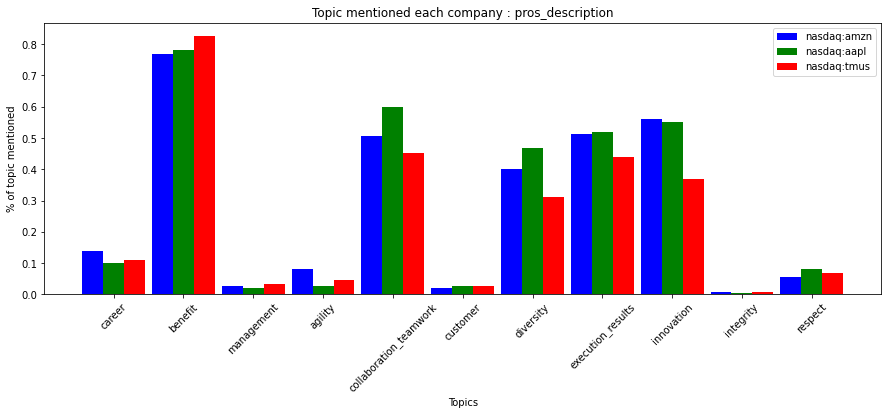

In [108]:
tn_id_list=["nasdaq:amzn","nasdaq:aapl","nasdaq:tmus"]
threshold=0.1
getTopicMentionedPerCompany('pros_description', y_preds_proba_pros, df_topics.columns, threshold, tn_id_list)

#df_co.head()

(20305, 15)
(11788, 15)
(22031, 15)
[0.0784535828613642, 0.8176803742920463, 0.07830583600098498, 0.12095542969711894, 0.45865550357054913, 0.010736271854223097, 0.558680128047279, 0.5246491012065994, 0.5392267914306821, 0.015661167200196995, 0.04545678404333908]
nasdaq:amzn


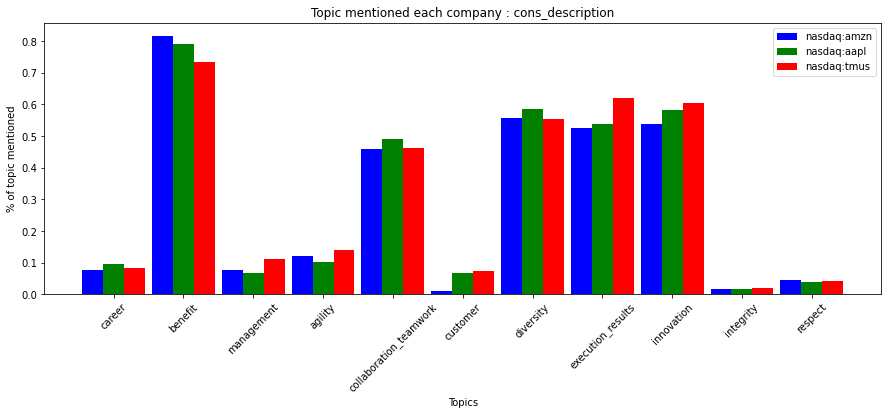

In [109]:
tn_id_list=["nasdaq:amzn","nasdaq:aapl","nasdaq:tmus"]
threshold=0.1
getTopicMentionedPerCompany('cons_description', y_preds_proba_cons, df_topics.columns, threshold, tn_id_list)


(11907, 15)
(7164, 15)
(10278, 15)
[0.09355841101872849, 0.6455866297136138, 0.15217939027462837, 0.06979087931468884, 0.5319559922734526, 0.022171831695641218, 0.5177626606198035, 0.6103972453178802, 0.6633072982279331, 0.026035105400184767, 0.17485512723607963]
nasdaq:amzn


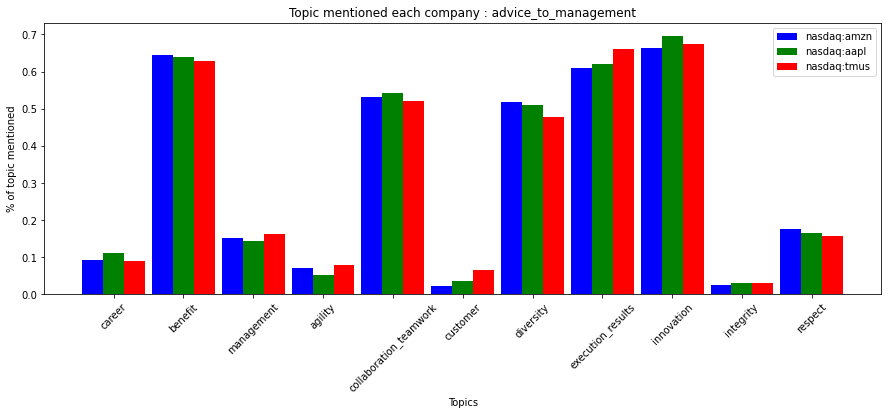

In [112]:
tn_id_list=["nasdaq:amzn","nasdaq:aapl","nasdaq:tmus"]
threshold=0.1
getTopicMentionedPerCompany('advice_to_management', y_preds_proba_mgr, df_topics.columns, threshold, tn_id_list)


In [114]:
# Advice to management , lots of missing input. 
desc='advice_to_management'
tmp_df=df_cleaned[['id','tn_id','as_of_date',desc]]
print(tmp_df.shape)
tmp_df.drop(tmp_df[tmp_df[desc]=='[SEP]'].index, inplace=True)
print(tmp_df.shape)
pd.options.display.max_colwidth = 100
tmp_df['advice_to_management'][:30]

(79372, 4)
(44409, 4)


3083                                                                                              good luck
3089                                                     management look person capable instead willing say
3090                                                                                              good work
3091                                                                              time train newbies better
3097                                                                      stop lying people going lose jobs
3098                                                               hire people based experience friendships
3099                                                                        speedup agile amp safe adoption
3100                                                                                let work home days week
3101                 cut training program 2weeks 1 week better bonuses available time occasionally weekends
3104                        

In [122]:
def getTopicProbsPerCompany(desc, preds_proba,  topics_list,  tn_id_list):
    df_class_prob=pd.DataFrame(preds_proba, columns=df_topics.columns)
    tmp_df=df_cleaned[['id','tn_id','as_of_date',desc]]
    tmp_df.drop(tmp_df[tmp_df[desc]=='[SEP]'].index, inplace=True) # sep is empty string here! was [SEP]
    df_tmp=pd.concat([df_class_prob,tmp_df], axis=1)
    
    mentions_all=[]
    for tn_id in tn_id_list:
        mentions={}
        df_co=df_tmp[df_tmp['tn_id']==tn_id]
        total_cnt=df_co.shape[0]
        for t in df_topics.columns:
            total_prob=df_co[t].sum()
            p=total_prob/total_cnt
            #print(t, total_prob, p)
            mentions[t]=p
        #print(df_co.shape)
        mentions_all.append(mentions)
        # plotTopicMentioned(mentions)
    #print(list(mentions_all[0].values()))
    plotTopicMentioned_compare(mentions_all, tn_id_list, desc)
    return mentions_all
    

nasdaq:amzn


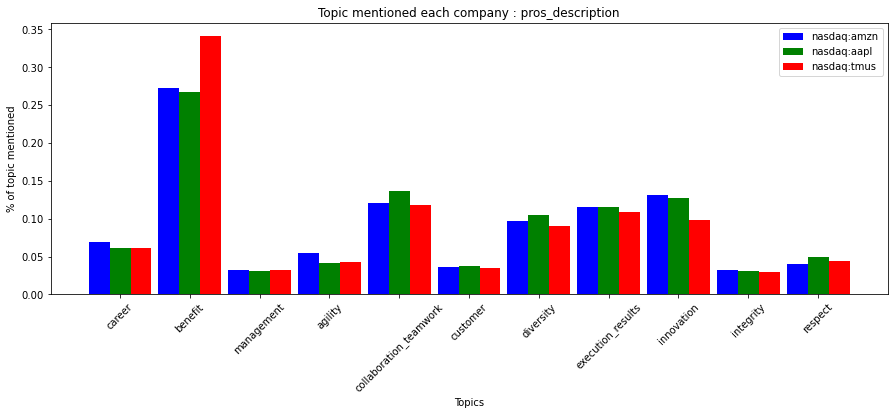

nasdaq:amzn


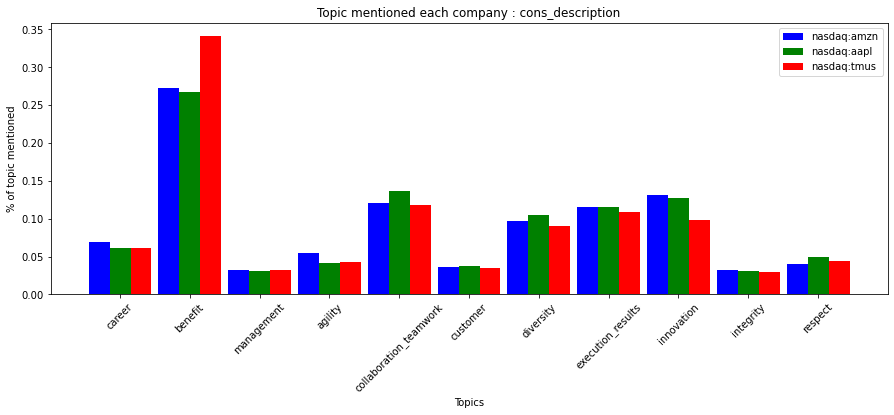

nasdaq:amzn


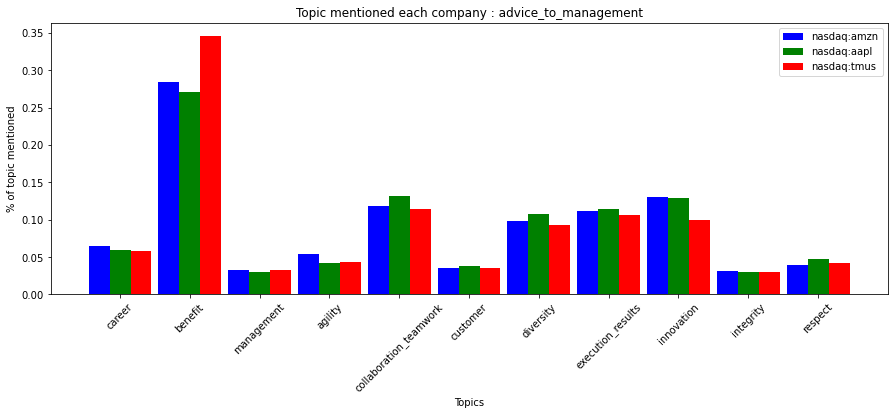

In [123]:
tn_id_list=["nasdaq:amzn","nasdaq:aapl","nasdaq:tmus"]
all_probs=getTopicProbsPerCompany('pros_description', y_preds_proba_pros, df_topics.columns,  tn_id_list)
all_probs=getTopicProbsPerCompany('cons_description', y_preds_proba_pros, df_topics.columns,  tn_id_list)
all_probs=getTopicProbsPerCompany('advice_to_management', y_preds_proba_pros, df_topics.columns,  tn_id_list)


nasdaq:amzn


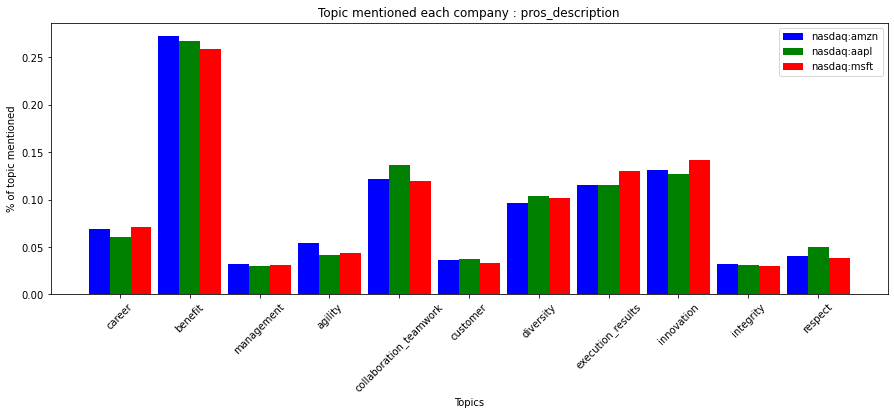

nasdaq:amzn


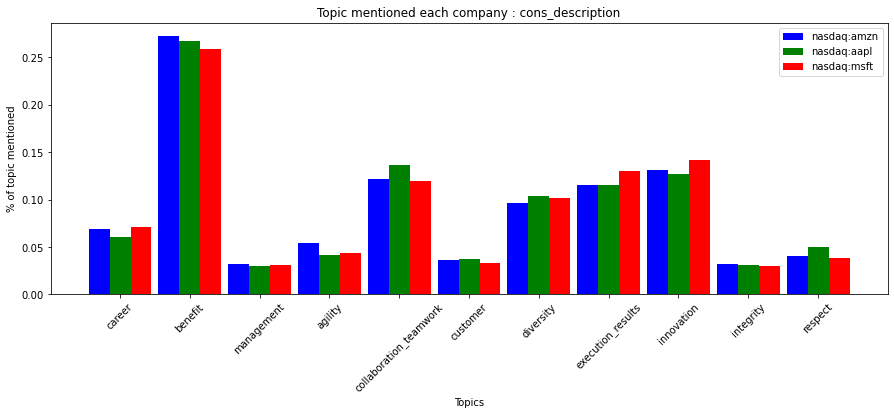

nasdaq:amzn


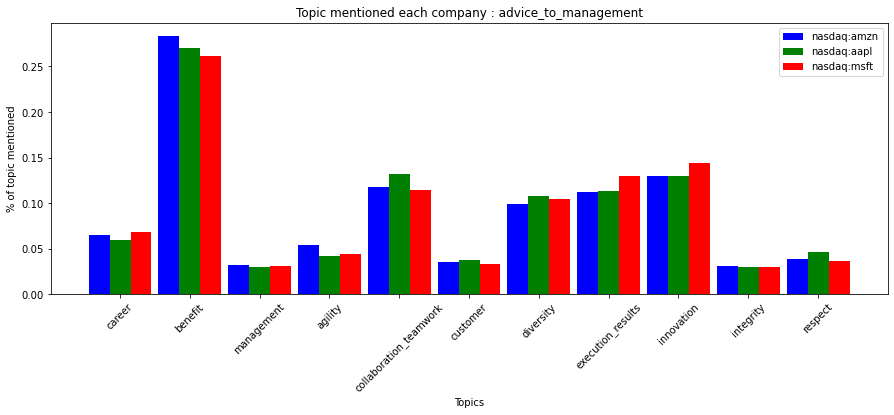

In [124]:
    
tn_id_list=["nasdaq:amzn","nasdaq:aapl","nasdaq:msft"]
all_probs=getTopicProbsPerCompany('pros_description', y_preds_proba_pros, df_topics.columns,  tn_id_list)
all_probs=getTopicProbsPerCompany('cons_description', y_preds_proba_pros, df_topics.columns,  tn_id_list)
all_probs=getTopicProbsPerCompany('advice_to_management', y_preds_proba_pros, df_topics.columns,  tn_id_list)

In [177]:
def getTopicProbsPerCompanyPerYear(desc, preds_proba,  topics_list,  tn_id_list):
    df_class_prob=pd.DataFrame(preds_proba, columns=df_topics.columns)
    tmp_df=df_cleaned[['id','tn_id','as_of_date',desc]]
    tmp_df.drop(tmp_df[tmp_df[desc]=='[SEP]'].index, inplace=True) # sep is empty string here! was [SEP]
    df_tmp=pd.concat([df_class_prob,tmp_df], axis=1)
    df_output=pd.DataFrame()
    
    
    
    for tn_id in tn_id_list:
        
        df_co=df_tmp[df_tmp['tn_id']==tn_id]
        df_co['year']=list(pd.DatetimeIndex(df_co['as_of_date']).year)
        
        # for each year
        for t in df_topics.columns:
            df_output['year']=sorted(df_co['year'].unique())
            
            probs=[]
            for year in sorted(df_co['year'].unique()):
                total_cnt=df_co[df_co['year']==year].shape[0]
                total_prob=df_co[df_co['year']==year][t].sum()
                p=total_prob/total_cnt
                #print(year, t, p)
                probs.append(p)
                
            df_output[t]=probs
        df_output.plot(x="year", y=df_topics.columns, kind="line", figsize=(10, 10))
        title=tn_id+": culture score over year"
        plt.title(title)
        plt.show()

    return df_output

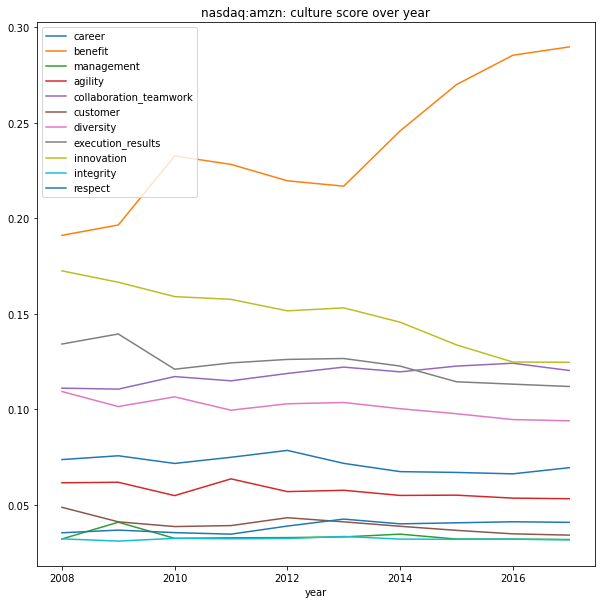

In [181]:
pd.options.mode.chained_assignment = None 
tn_id_list=["nasdaq:amzn"]
probs_perYear=getTopicProbsPerCompanyPerYear('pros_description', y_preds_proba_pros, df_topics.columns,  tn_id_list)

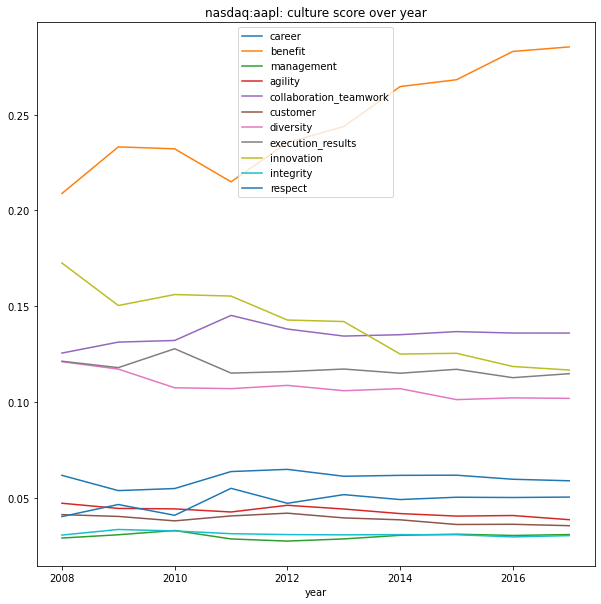

In [182]:
tn_id_list=["nasdaq:aapl"] 
probs_perYear=getTopicProbsPerCompanyPerYear('pros_description', y_preds_proba_pros, df_topics.columns,  tn_id_list)

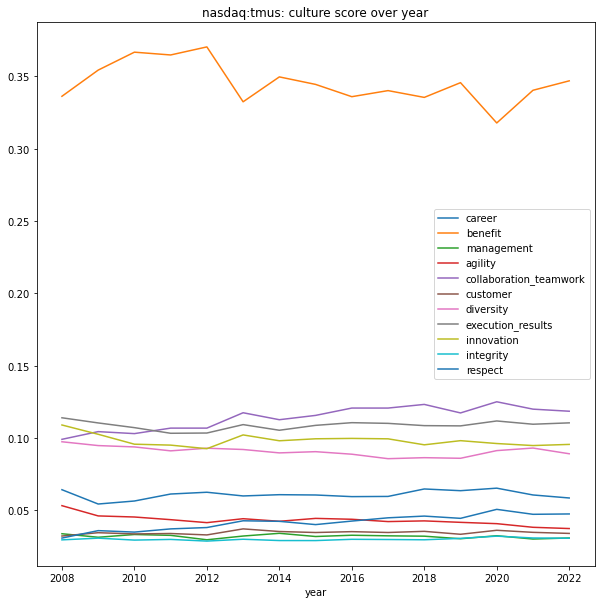

In [183]:
tn_id_list=["nasdaq:tmus"] 
probs_perYear=getTopicProbsPerCompanyPerYear('pros_description', y_preds_proba_pros, df_topics.columns,  tn_id_list)

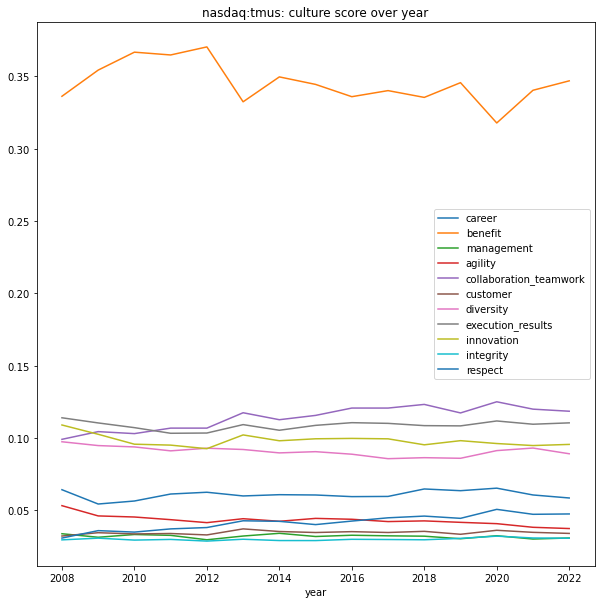

In [184]:
tn_id_list=["nasdaq:tmus"] 
probs_perYear=getTopicProbsPerCompanyPerYear('pros_description', y_preds_proba_pros, df_topics.columns,  tn_id_list)

In [185]:
review=embed("advancement")
e1=embed("advance")
for topic in topics:
    sim=sklean.cos_sim(review,topic)
print(e)

tf.Tensor(
[[ 1.15659289e-01 -2.47090906e-02  3.50939785e-03 -2.29512192e-02
  -1.29886493e-02 -4.92662936e-02  3.24969776e-02  3.21641192e-02
   7.11942911e-02 -6.95624128e-02 -1.07840551e-02  7.70025980e-03
  -9.46684927e-02 -8.95157978e-02 -6.24770895e-02 -7.24823959e-03
   1.78227555e-02  6.64285664e-03 -2.03837138e-02  3.12604271e-02
  -3.25546190e-02  1.07416563e-01 -2.98382062e-02 -1.22607052e-02
   5.00345267e-02  8.64102542e-02 -1.30258605e-03 -1.10984370e-02
  -4.09956500e-02  1.17361927e-02  1.19969563e-03  5.13988920e-02
  -1.84397548e-02 -4.78022881e-02 -6.95266179e-04 -5.22688292e-02
  -3.14420164e-02  1.20757939e-02 -1.58007406e-02  2.95650922e-02
  -5.88997900e-02  2.43314840e-02 -1.65087054e-03 -3.73206101e-02
  -8.53115395e-02 -4.74234000e-02 -5.40912058e-03  2.87162773e-02
  -7.90048856e-03  6.03940561e-02 -3.14743631e-02 -5.27376346e-02
   2.72328053e-02 -5.55286370e-02  1.61676165e-02 -1.14971079e-01
   3.69140767e-02  7.36771431e-03 -2.52842177e-02  1.13340998e-02